In [58]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import astropy.units as u
from datetime import datetime
import pickle, json, sys, os
import pandas as pd
pd.set_option('display.max_columns', None)

from astropy.coordinates import SkyCoord
from scipy.stats import chi2
from scipy.optimize import minimize
from astropy.table import Table

# location of the scripts
sys.path.insert(0, os.path.join("/fefs/aswg/workspace/juan.jimenez/lst1_systematics/scripts"))
import auxiliar as aux
import geometry as geom

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))


# ============================ #
dict_path = "objects/dict_total.pkl"
# ============================ #

### Reading all the objects and putting all the information in a unique dict

In [2]:
%%time
# reading dict
with open(dict_path, 'rb') as f:
    dict_total = pickle.load(f)

dict_runs    = dict_total["run"]
dict_general = dict_total["general"] 

Ibins  = dict_total["general"]["intensity_bins"]
IbinsC = dict_total["general"]["intensity_bins_centers"]

total_zds = [dict_runs[run]["zd"] for run in dict_runs.keys()]

CPU times: user 4.51 ms, sys: 3.72 ms, total: 8.23 ms
Wall time: 5.77 ms


### Effective time correction

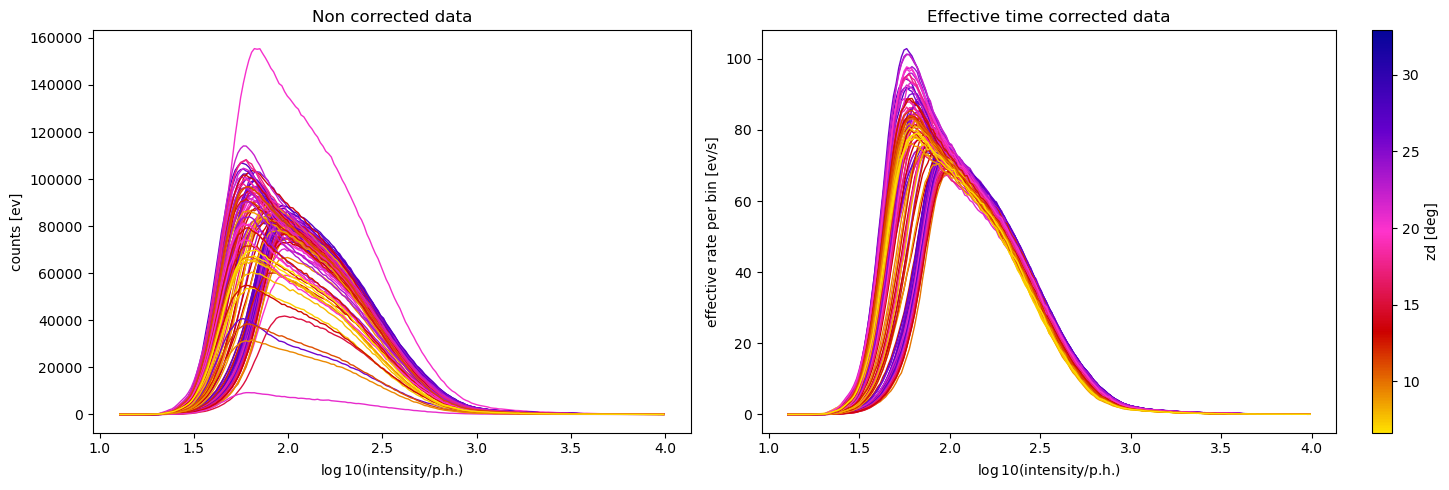

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), gridspec_kw={'width_ratios': [1, 1.2]})

# Getting the color array for the ZDs
colors = aux.get_colors_multiplot(total_zds, COLORS=list(reversed(aux.predC)))
cmap   = aux.create_cmap(list(reversed(aux.predC)))

# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax1.plot(IbinsC, dict_runs[run]["intensity_rates"] * dict_runs[run]["effective_time"], color=colors[i], lw=1)
    ax2.plot(IbinsC, dict_runs[run]["intensity_rates"]                                   , color=colors[i], lw=1)

# creating a colorbar
aux.plot_colorbar(fig, ax2, total_zds, cmap, label="zd [deg]")

for ax in [ax1, ax2]:
    ax.set_xlabel("$\log10($intensity/p.h.$)$")
ax1.set_ylabel("counts [ev]")
ax2.set_ylabel("effective rate per bin [ev/s]")
ax1.set_title("Non corrected data")
ax2.set_title("Effective time corrected data")
fig.tight_layout()
plt.show()

### Computing counts

In [117]:
N = 200
i_min = np.linspace(np.log10(10), 3.9, N)
i_max = 4

# Then we plot the intensity profiles one by one
p_rates = []
for j in range(len(i_min)):
    
    # select the bins that are inside the integral
    flag_bins = []
    for i in range(len(Ibins)-1):
        if Ibins[i] > i_min[j] and Ibins[i+1] < i_max:
            flag_bins.append(True)
        else:
            flag_bins.append(False)
        
    _p_rate = []
    for i, run in enumerate(dict_runs.keys()):  
        
        rates = dict_runs[run]["intensity_rates"]

        # --- Compute the integral of p rate in the integral range --- #
        integral = np.sum(rates[flag_bins])
        _p_rate.append(integral)
        
    p_rates.append(np.array(_p_rate))
    
p_rates = np.array(p_rates)

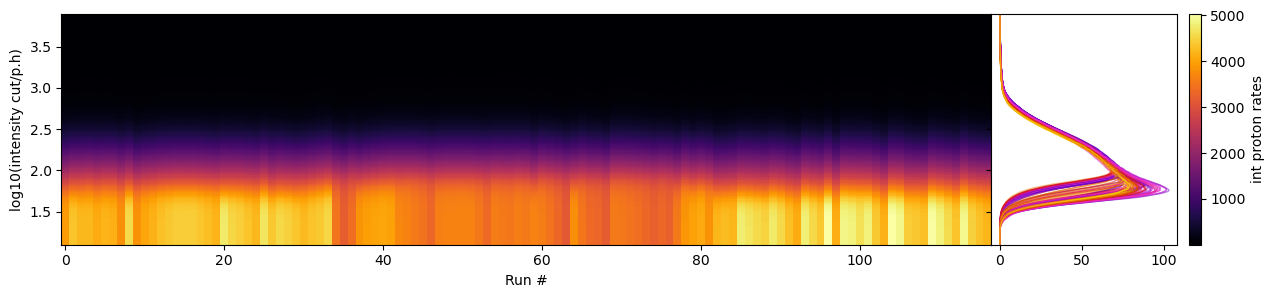

In [238]:
fig, (ax, ax2) = plt.subplots(1, 2, figsize=(15, 3), gridspec_kw={'width_ratios': [4, 1]}, sharey=True)
cm = ax.pcolormesh(np.arange(len(p_rates.T)), i_min, p_rates, cmap="inferno")
fig.colorbar(cm, ax=ax2, label="int proton rates")

# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax2.plot(dict_runs[run]["intensity_rates"], IbinsC, color=colors[i], lw=1, alpha=0.5)

ax2.set_ylim(1.1, 3.9) 
ax.set_ylabel("log10(intensity cut/p.h)")
ax.set_xlabel("Run #")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

### Extracting all the values in arrays

In [213]:
# extracting values as arrays
p_rate, e_p_rate = [], []
flux,   e_flux   = [], []
zd,     az       = [], []
e_zd,   e_az     = [], []

for run in np.sort(list(dict_runs.keys())):
    flux.append(dict_runs[run]["flux"])
    e_flux.append(dict_runs[run]["e_flux"])
    zd.append(dict_runs[run]["zd"])
    az.append(dict_runs[run]["az"])
    
    _e_p_rate = np.sqrt(dict_runs[run]["n_events"]) / dict_runs[run]["effective_time"]
    dict_runs[run]["e_p_rate"] = _e_p_rate
    e_p_rate.append(_e_p_rate)

for array in [flux, e_flux, e_p_rate, zd, az]:
    array = np.array(array)

### Linearly fitting the zd to the proton rate and showing all distributions

In [ ]:
def calculate_chi2_pvalue(x, y, uy, sys_error=0):
    uncertainty = np.sqrt((sys_error * y)**2 + np.array(uy)**2)
    
    mean_flux     = (y/uncertainty**2).sum() / (1/uncertainty**2).sum()
    mean_flux_err = np.sqrt(1/np.sum(1/uncertainty**2))
    
    chi2_value = np.sum((y - mean_flux)**2/uncertainty**2)
    ndf = len(y) - 1
    pvalue = chi2.sf(x=chi2_value, df=ndf)
    return chi2_value, ndf, pvalue

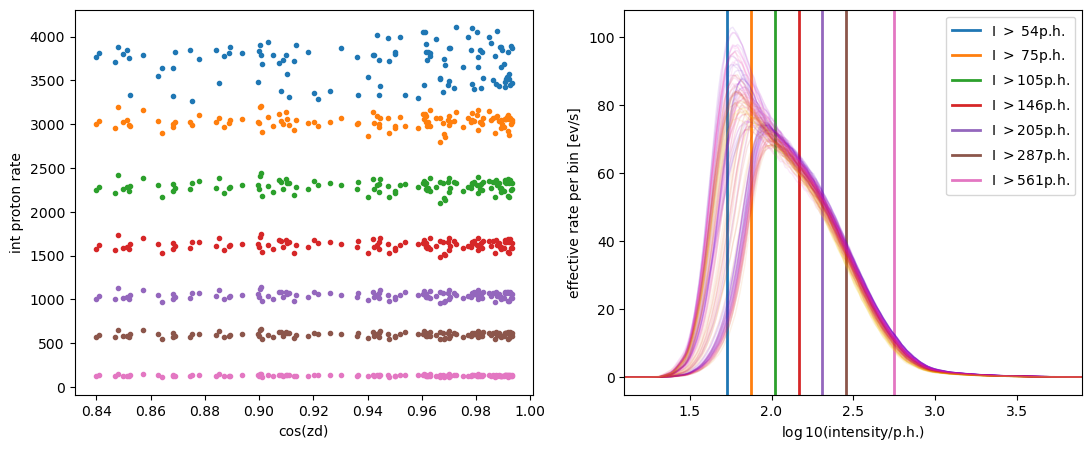

In [264]:
slope, inter     = [], []
chi2arr, pvalues = [], []
corr_p_rates = []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

iplots = [50, 60, 70, 80, 90, 100, 120]
colors_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

index = 0
for i in range(len(p_rates)):

    # Perform linear fits
    fit = np.poly1d(np.polyfit(np.cos(np.deg2rad(zd)), p_rates[i], 1))
    
    coefs = fit.coef
    slope.append(coefs[0])
    inter.append(coefs[1])
    
    zd_corr_p_rate = p_rates[i] - fit(np.cos(np.deg2rad(zd))) + fit(1)
    
    chi2_value, ndf, pvalue = calculate_chi2_pvalue(np.cos(np.deg2rad(zd)), zd_corr_p_rate, e_p_rate, sys_error=0)
    chi2arr.append(chi2_value)
    pvalues.append(pvalue)
    stdvs.append(np.std(zd_corr_p_rate))

    if i in iplots:
        ax1.errorbar(np.cos(np.deg2rad(zd)), zd_corr_p_rate, yerr=e_p_rate, marker=".", ls="", color=colors_cycle[index],
                   label=f"I $>${10**i_min[i]:3.0f}p.h.")
        ax2.axvline(i_min[i], color=colors_cycle[index], lw=2, label=f"I $>${10**i_min[i]:3.0f}p.h.")
        index = index + 1
        
    corr_p_rates.append(zd_corr_p_rate)
        
# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax2.plot(IbinsC, dict_runs[run]["intensity_rates"], color=colors[i], lw=1, alpha=0.1)
        
ax2.set_xlim(1.1, 3.9)        
ax2.legend()
ax1.set_ylabel("int proton rate")
ax1.set_xlabel("cos(zd)")
ax2.set_xlabel("$\log10($intensity/p.h.$)$")
ax2.set_ylabel("effective rate per bin [ev/s]")
plt.show()

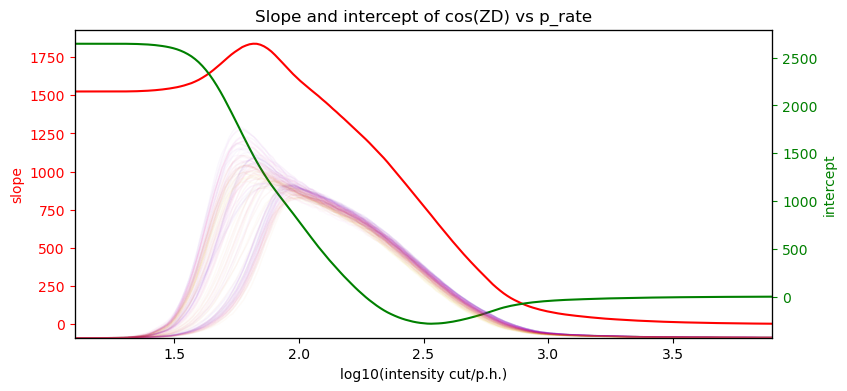

In [265]:
fig, (ax1) = plt.subplots(figsize=(9, 4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()


p1, = ax1.plot(i_min, slope, color="r")
p2, = ax2.plot(i_min, inter, color="g")

ax1.set_ylabel("slope")
ax2.set_ylabel("intercept")
for ax in [ax1, ax2]:
    ax.set_xlabel("log10(intensity cut/p.h.)")
    
    
# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax3.plot(IbinsC, dict_runs[run]["intensity_rates"], color=colors[i], lw=1, alpha=0.03)
             
             
ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax1.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())

ax3.set_yticks([])
ax3.set_ylim(0, 150)
ax1.set_xlim(1.1, 3.9)
ax1.set_title("Slope and intercept of cos(ZD) vs p_rate")
plt.show()

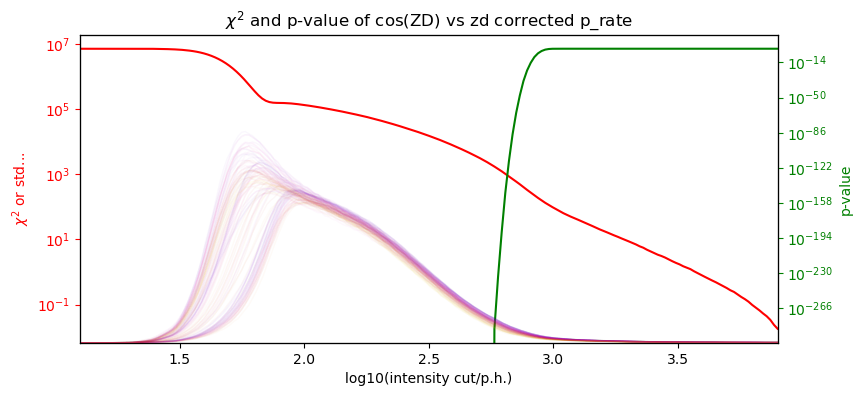

In [266]:
fig, (ax1) = plt.subplots(figsize=(9, 4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

p1, = ax1.plot(i_min, chi2arr, color="r")
p2, = ax2.plot(i_min, pvalues, color="g")

ax1.set_ylabel("$\chi^2$ or std...")
ax2.set_ylabel("p-value")
for ax in [ax1, ax2]:
    ax.set_xlabel("log10(intensity cut/p.h.)")
    
    
# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax3.plot(IbinsC, dict_runs[run]["intensity_rates"], color=colors[i], lw=1, alpha=0.03)
             
             
ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax1.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
ax1.set_yscale("log")
ax2.set_yscale("log")
ax3.set_yticks([])
ax3.set_ylim(0, 150)
ax1.set_xlim(1.1, 3.9)
ax1.set_title("$\chi^2$ and p-value of cos(ZD) vs zd corrected p_rate")
plt.show()

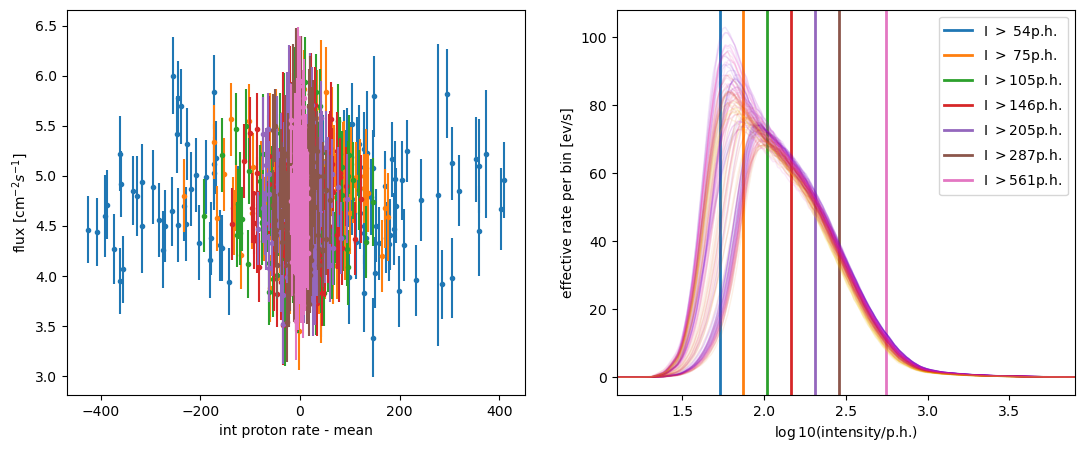

In [281]:
slope, inter     = [], []
chi2arr, pvalues = [], []

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))

iplots = [50, 60, 70, 80, 90, 100, 120]
colors_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

index = 0
for i in range(len(corr_p_rates)):

    # Perform linear fits
    fit = np.poly1d(np.polyfit(corr_p_rates[i], flux, 1))
    
    coefs = fit.coef
    slope.append(coefs[0])
    inter.append(coefs[1])
    
    corr_flux = flux - (fit(corr_p_rates[i]) - np.mean(flux))

    chi2_value, ndf, pvalue = calculate_chi2_pvalue(corr_p_rates[i], corr_flux, e_flux, sys_error=0)
    chi2arr.append(chi2_value)
    pvalues.append(pvalue)
    stdvs.append(np.std(zd_corr_p_rate))

    if i in iplots:
        ax1.errorbar(corr_p_rates[i] - np.mean(corr_p_rates[i]), corr_flux, yerr=e_flux, marker=".", ls="", color=colors_cycle[index], zorder=i,
                   label=f"I $>${10**i_min[i]:3.0f}p.h.")
        ax2.axvline(i_min[i], color=colors_cycle[index], lw=2, label=f"I $>${10**i_min[i]:3.0f}p.h.")
        index = index + 1
        
        
# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax2.plot(IbinsC, dict_runs[run]["intensity_rates"], color=colors[i], lw=1, alpha=0.1)
        
ax2.set_xlim(1.1, 3.9)        
ax2.legend()
ax1.set_ylabel("flux [cm$^{-2}s^{-1}$]")
ax1.set_xlabel("int proton rate - mean")
ax2.set_xlabel("$\log10($intensity/p.h.$)$")
ax2.set_ylabel("effective rate per bin [ev/s]")
plt.show()

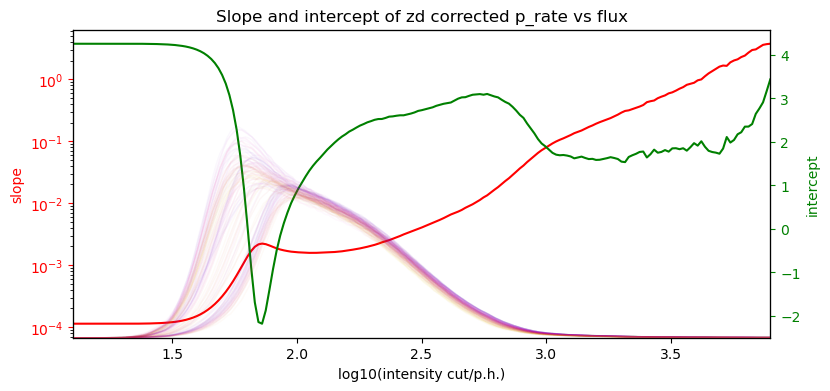

In [271]:
fig, (ax1) = plt.subplots(figsize=(9, 4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()


p1, = ax1.plot(i_min, slope, color="r")
p2, = ax2.plot(i_min, inter, color="g")

ax1.set_ylabel("slope")
ax2.set_ylabel("intercept")
for ax in [ax1, ax2]:
    ax.set_xlabel("log10(intensity cut/p.h.)")
    
    
# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax3.plot(IbinsC, dict_runs[run]["intensity_rates"], color=colors[i], lw=1, alpha=0.03)
             
             
ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax1.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())

ax1.set_yscale("log")
ax3.set_yticks([])
ax3.set_ylim(0, 150)
ax1.set_xlim(1.1, 3.9)
ax1.set_title("Slope and intercept of zd corrected p_rate vs flux")
plt.show()

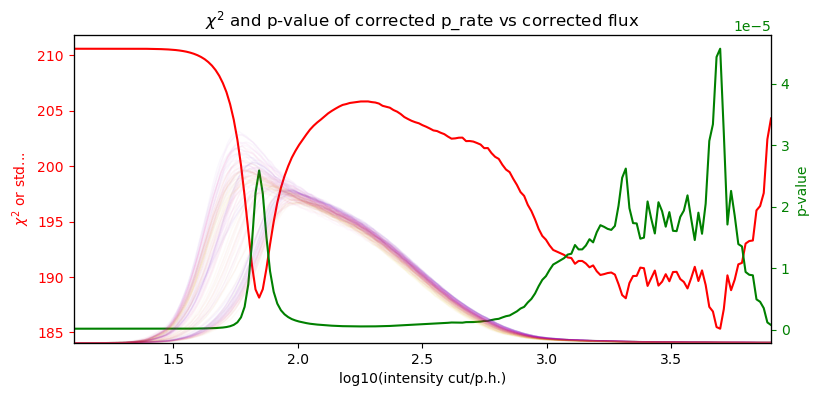

In [272]:
fig, (ax1) = plt.subplots(figsize=(9, 4))
ax2 = ax1.twinx()
ax3 = ax1.twinx()

p1, = ax1.plot(i_min, chi2arr, color="r")
p2, = ax2.plot(i_min, pvalues, color="g")

ax1.set_ylabel("$\chi^2$ or std...")
ax2.set_ylabel("p-value")
for ax in [ax1, ax2]:
    ax.set_xlabel("log10(intensity cut/p.h.)")
    
    
# Then we plot the intensity profiles one by one
for i, run in enumerate(dict_runs.keys()):  
    ax3.plot(IbinsC, dict_runs[run]["intensity_rates"], color=colors[i], lw=1, alpha=0.03)
             
             
ax1.yaxis.label.set_color(p1.get_color())
ax2.yaxis.label.set_color(p2.get_color())
ax1.tick_params(axis='y', colors=p1.get_color())
ax2.tick_params(axis='y', colors=p2.get_color())
# ax1.set_yscale("log")
# ax2.set_yscale("log")
ax3.set_yticks([])
ax3.set_ylim(0, 150)
ax1.set_xlim(1.1, 3.9)
ax1.set_title("$\chi^2$ and p-value of corrected p_rate vs corrected flux")
plt.show()

In [285]:
N = 20
i_min = np.linspace(np.log10(10), 3.9, N)
i_max = 4

# Then we plot the intensity profiles one by one
p_rates = []
for j in range(len(i_min)):

    _p_rates_min = []
    for k in range(len(i_min) - j - 2):
        
        i_max = i_min[j] + (i_min[1] - i_min[0]) * (k + 1)
    
        # select the bins that are inside the integral
        flag_bins = []
        for i in range(len(Ibins)-1):
            if Ibins[i] > i_min[j] and Ibins[i+1] < i_max:
                flag_bins.append(True)
            else:
                flag_bins.append(False)

        _p_rates_run = []
        for i, run in enumerate(dict_runs.keys()):  

            rates = dict_runs[run]["intensity_rates"]

            # --- Compute the integral of p rate in the integral range --- #
            integral = np.sum(rates[flag_bins])
            _p_rates_run.append(integral)

        _p_rates_min.append(np.array(_p_rates_run))
        
    p_rates.append(_p_rates_min)
    
# p_rates = np.array(p_rates)

In [ ]:
plt.plot(p_rates[10][8]);